In [1]:
#? load libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from tqdm import tqdm

from tensorflow.keras.models import load_model

In [2]:
#? define global vars
MODEL_PATH = './models/ocr_model_augmented_optimized'
IMAGE_PATH = './tests/Paper-Pen-Robert.jpg'

LABEL_DIRECTORY = './dataset-mapping.txt'

In [3]:
#? load the model
model = load_model(MODEL_PATH)

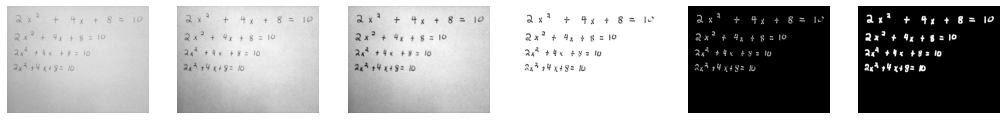

In [4]:
#? load and pre-process the image
img = cv2.imread(IMAGE_PATH, 0)
blured = cv2.medianBlur(img,5)

kernel = np.ones((6, 6), np.uint8)
eroded = cv2.erode(blured, kernel, cv2.BORDER_REFLECT) 

denoised_1 = cv2.fastNlMeansDenoising(eroded, 10, 7, 21) 

thresh = cv2.adaptiveThreshold(denoised_1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

denoised_2 = cv2.fastNlMeansDenoising(thresh, 10, 7, 21) 
denoised_2 = cv2.bitwise_not(denoised_2)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dialated = cv2.dilate(denoised_2, kernel, iterations=3)

fig = plt.figure(figsize=(30, 30))
fig.add_subplot(1, 10, 1)
plt.axis('off')
plt.imshow(img, 'gray')

fig.add_subplot(1, 10, 2)
plt.axis('off')
plt.imshow(blured, 'gray')

fig.add_subplot(1, 10, 3)
plt.axis('off')
plt.imshow(eroded, 'gray')

fig.add_subplot(1, 10, 4)
plt.axis('off')
plt.imshow(thresh, 'gray')

fig.add_subplot(1, 10, 5)
plt.axis('off')
plt.imshow(denoised_2, 'gray')

fig.add_subplot(1, 10, 6)
plt.axis('off')
plt.imshow(dialated, 'gray')

plt.show()

im2, ctrs, hier = cv2.findContours(dialated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

In [5]:
i = 0

chars = []

# loop over the contours
for c in tqdm(sorted_ctrs):

    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small nor too large

    a = w * h

    if w > 15 and h > 15 and w < 600 and h < 600:
        i += 1

        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = denoised_1[y:y + h, x:x + w]

        # if the width is greater than the height, resize along the
        # width dimension
        if w > h:
            roi = imutils.resize(roi, width=24)
        else: # otherwise, resize along the height
            roi = imutils.resize(roi, height=24)

        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 28x28
        (tH, tW) = roi.shape
        dX = int(max(0, 28 - tW) / 2.0)
        dY = int(max(0, 28 - tH) / 2.0)

        # binarize the image
        ret, img_thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img_thresh = cv2.bitwise_not(img_thresh)

        # pad the image and force 28x28 dimensions
        padded = cv2.copyMakeBorder(img_thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
        padded = cv2.resize(padded, (28, 28))

        ret, padded = cv2.threshold(padded, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32")
        padded = padded / 255

        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

100%|██████████| 73/73 [00:00<00:00, 24333.16it/s]


In [6]:
# make sure that no bounding boxes are completely contained by another
valid_chars = []
for c1 in chars:

    x1, y1, w1, h1 = c1[1]

    outside = True
    for c2 in chars:

        x2, y2, w2, h2 = c2[1]
        
        if not (x1, y1, w1, h1) == (x2, y2, w2, h2):

            if (x1 > x2 and y1 > y2 and x1+w1 < x2+w2 and y1+h1 < y2+h2):
                outside = False
                break
    
    if outside:
        valid_chars.append(c1)

chars = valid_chars     

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


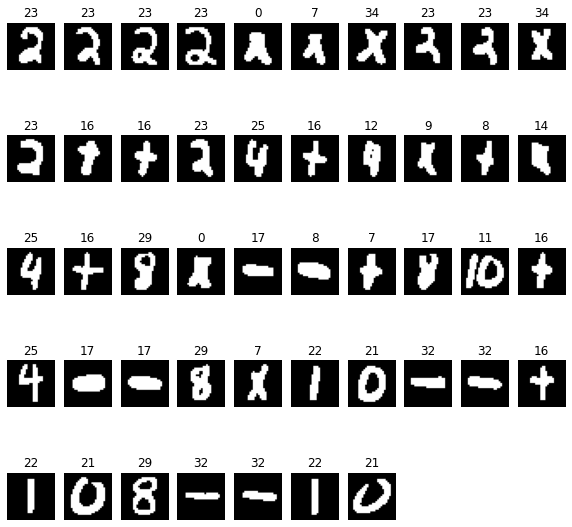

In [7]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
inputs = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(inputs.reshape((-1, 28, 28, 1)))

#? create a lable dictionary
label_map = pd.read_csv(LABEL_DIRECTORY,
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)

label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

fig = plt.figure(figsize=(10, 10))

rows = 5
cols = int(len(inputs) / rows) + 1

for i in range(len(inputs)):

    fig.add_subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(inputs[i], 'gray')
    plt.title(f'{preds[i].argmax()}')
    plt.clim(0, 1)

plt.show()

In [8]:
#? group the identified boxes into lines
MAX_X_OFFSET = 600

uncategorised = boxes.copy()
lines = []
line_boxes = []

min_x, max_x, min_y, max_y = 0, 0, 0, 0

while len(uncategorised) != 0:

    # initialize the bounding box to it's negative
    (x, y, w, h) = uncategorised[0]
    min_x = x
    min_y = y
    max_x = x+w
    max_y = y+h

    line = []

    # continue looping until no new boxes are found
    done = False
    while not done:

        # assume that no new boxes will be found.  If a box is found it will set done to false
        done = True

        # loop over each box in reverse order
        i = len(uncategorised) - 1
        while i >= 0:

            # see if this bounding box overlaps with the [min_y] or [max_y]
            (x, y, w, h) = uncategorised[i]
            if (min_y <= y <= max_y) or (min_y <= y+h <= max_y):

                # update the min/max bounding box
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x + w)
                max_y = max(max_y, y + h)

                # add this char to the line and remove it from uncategorised
                line.append(uncategorised[i])
                uncategorised.pop(i)

                done = False # update done to false since new boxes could be fond

            i -= 1

    # add the line
    lines.append(line)
    line_boxes.append((
        min_x, min_y, max_x, max_y # x1, y1, x2, y2
    ))

# draw the line bounding boxes on the image
if (len(lines) != 0):
    for (x1, y1, x2, y2) in line_boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

In [9]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = label_dictionary[i]

    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, label, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # show the image
    cv2.imshow("Image", img)
    cv2.waitKey(0)

[INFO] 2 - 99.58%
[INFO] 2 - 98.51%
[INFO] 2 - 99.57%
[INFO] 2 - 99.12%
[INFO] A - 36.69%
[INFO] H - 21.65%
[INFO] X - 87.47%
[INFO] 2 - 62.39%
[INFO] 2 - 54.01%
[INFO] X - 44.09%
[INFO] 2 - 65.42%
[INFO] U - 23.00%
[INFO] U - 71.61%
[INFO] 2 - 87.44%
[INFO] 4 - 62.36%
[INFO] U - 81.68%
[INFO] P - 28.59%
[INFO] K - 32.71%
[INFO] J - 19.54%
[INFO] R - 25.60%
[INFO] 4 - 86.76%
[INFO] U - 67.14%
[INFO] 8 - 35.59%
[INFO] A - 19.87%
[INFO] V - 14.83%
[INFO] J - 24.58%
[INFO] H - 52.48%
[INFO] V - 60.83%
[INFO] N - 75.45%
[INFO] U - 53.56%
[INFO] 4 - 97.42%
[INFO] V - 30.73%
[INFO] V - 26.31%
[INFO] 8 - 27.72%
[INFO] H - 19.33%
[INFO] 1 - 88.29%
[INFO] 0 - 93.74%
[INFO] - - 76.42%
[INFO] - - 10.96%
[INFO] U - 61.57%
[INFO] 1 - 80.60%
[INFO] 0 - 87.57%
[INFO] 8 - 90.74%
[INFO] - - 95.58%
[INFO] - - 65.65%
[INFO] 1 - 73.01%
[INFO] 0 - 83.86%
